In [23]:
# generic imports 

from bydoux_tools import read_google_sheet_csv
import numpy as np
from scipy.optimize import minimize
import bydoux_tools as bt
from astropy.time import Time
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from tqdm import tqdm



In [24]:
# Parameters for the code that may change
force = False

t0 = Time('2024-05-01', format='iso').mjd
t1 = Time.now().mjd

In [25]:
# Fetch the disnat summary table of my accounts

tbl = bt.get_disnat_summary()
tbl = tbl[np.argsort(tbl['mjd'])]


Empty table


Removing duplicates: 100%|██████████| 276/276 [00:00<00:00, 1425.37it/s]


In [26]:
# Constructing a time span for the analysis
# add S&P 500 and CADUSD data
# to the table
time_span = np.arange(t0, t1, 1)

tbl0 = Table()
tbl0['mjd'] = time_span

sp500 = bt.read_quotes('^SPX', force=force)


cadusd = bt.read_quotes('CADUSD=X', force=force)

tbl0['CADUSD'] = np.interp(tbl0['mjd'],cadusd['mjd'],cadusd['Close'])

tbl['SP500']=np.interp(tbl['mjd'],sp500['mjd'],sp500['Close'])
tbl0['SP500']=np.interp(tbl0['mjd'],sp500['mjd'],sp500['Close'])
tbl0['N_SP500'] = 0.0
tbl0['CONTRIBUTIONS'] = 0.0

for i in tqdm(range(len(tbl))):
    if tbl['Devise du prix'][i] != 'CAN':
        continue
    if tbl['Type de transaction'][i] == 'COTISATION':
        g = tbl0['mjd']>tbl['mjd'][i]
        tbl0['CONTRIBUTIONS'][g] += tbl["Montant de l'opération"][i]
        #print(tbl["Montant de l'opération"][i])


    if tbl['Type de transaction'][i] == 'TRANSFERT REÇU':
        g = tbl0['mjd']>tbl['mjd'][i]
        tbl0['CONTRIBUTIONS'][g] += tbl["Montant de l'opération"][i]
    
        #print(tbl['Devise du prix'][i])
        #print(tbl['Date de transaction'][i],tbl["Montant de l'opération"][i])

We have the file /Users/eartigau/bydoux_data/quotes/^SPX.fits
0.2105612134328112
We have the file /Users/eartigau/bydoux_data/quotes/CADUSD=X.fits
0.21052555893402314


100%|██████████| 185/185 [00:00<00:00, 72073.77it/s]


In [27]:
# get the symbol of all actions bought or sold 'Type de transaction' is 'ACHAT' or 'VENTE'

flag = [
    True if ('ACHAT' in x or 'VENTE' in x) else False
    for x in tbl['Type de transaction']
]
symbols = np.unique(tbl[flag]['Symbole'])

# trim -C and -U from the symbols, add .TO

problems = []
for sym in symbols:
    sym2 = sym.split('-')[0]
    sym2 = sym2.split('.')[0]

    # get the quotes for the symbol
    
    quotes = None
    try:
        quotes = bt.read_quotes(sym2+'.TO', force=force)
    except Exception as e:
        print(f"Error reading {sym2}.TO: {e}")

    if type(quotes) == type(None):
        quotes = bt.read_quotes(sym2, force=force)

    if type(quotes) == type(None):
        problems.append(sym)
        continue

    val = np.interp(tbl0['mjd'],quotes['mjd'],quotes['Close'])
    val_close_dividend = np.interp(tbl0['mjd'],quotes['mjd'],quotes['Close_dividends'])
    tbl0[sym] = val
    tbl0[sym+'_dividend'] = val_close_dividend

    tbl0[sym+'_quantity'] = 0
    tbl0[sym+'_val'] = 0.0


for i in range(len(tbl)):
    if ('ACHAT' in tbl['Type de transaction'][i]) or ('VENTE' in tbl['Type de transaction'][i]):
        sym = tbl['Symbole'][i]

        g = tbl0['mjd']>tbl['mjd'][i]
        #print(sym, tbl['Quantité'][i])
        tbl0[sym+'_quantity'][g] += tbl['Quantité'][i]

        if '-U' in sym:
            tbl0[sym+'_val'][g] += tbl['Quantité'][i] * tbl0[sym][g]/ tbl0['CADUSD'][g]
        else:
            tbl0[sym+'_val'][g] += tbl['Quantité'][i] * tbl0[sym][g]

01:24:54.228 |  Failed to read AXON.TO from Yahoo
01:24:54.229 |  We will not try again
We have the file /Users/eartigau/bydoux_data/quotes/AXON.fits
0.21048614520259434
We have the file /Users/eartigau/bydoux_data/quotes/BKCL.TO.fits
0.21048050081299152
We have the file /Users/eartigau/bydoux_data/quotes/BNS.TO.fits
0.2104281205611187
01:24:54.293 |  Failed to read CHRW.TO from Yahoo
01:24:54.293 |  We will not try again
We have the file /Users/eartigau/bydoux_data/quotes/CHRW.fits
0.21038298799248878
We have the file /Users/eartigau/bydoux_data/quotes/DMEC.TO.fits
0.2103791704212199
We have the file /Users/eartigau/bydoux_data/quotes/DRFC.TO.fits
0.21036599988292437
We have the file /Users/eartigau/bydoux_data/quotes/EBNK.TO.fits
0.21035863988799974
We have the file /Users/eartigau/bydoux_data/quotes/FCUV.TO.fits
0.21034729662642349
We have the file /Users/eartigau/bydoux_data/quotes/FFH.TO.fits
0.21029662920773262
01:24:54.426 |  Failed to read FICO.TO from Yahoo
01:24:54.426 |  We 

$VTR.TO: possibly delisted; no price data found  (period=5d)


Error reading VTR.TO: cannot guess format from input values with zero-size array or all elements masked
We have the file /Users/eartigau/bydoux_data/quotes/VTR.fits
0.20998744769894984
We have the file /Users/eartigau/bydoux_data/quotes/XUSC.TO.fits
0.20998393645277247
We have the file /Users/eartigau/bydoux_data/quotes/XUSC.TO.fits
0.2099841747622122
We have the file /Users/eartigau/bydoux_data/quotes/ZEA.TO.fits
0.20996241652755998
We have the file /Users/eartigau/bydoux_data/quotes/ZGLD.TO.fits
0.2099584303505253
We have the file /Users/eartigau/bydoux_data/quotes/ZLB.TO.fits
0.20993422660103533
We have the file /Users/eartigau/bydoux_data/quotes/ZLU.TO.fits
0.20991249522194266


In [28]:
tbl0['val_total'] = 0.0

for sym in symbols:
    tbl0['val_total'] += tbl0[sym+'_val']


percent_gains = [-10,-5,5,10,15,20]

for i in range(1,len(tbl0)):
    tbl0['N_SP500'][i] = tbl0['N_SP500'][i-1] 
    if np.round(tbl0['CONTRIBUTIONS'][i]) != np.round(tbl0['CONTRIBUTIONS'][i-1]):
        print(tbl0['CONTRIBUTIONS'][i])
        cont = (tbl0['CONTRIBUTIONS'][i] - tbl0['CONTRIBUTIONS'][i-1]) 
        nsp500 = cont/tbl0['SP500'][i]
        tbl0['N_SP500'][i] += nsp500

tbl0['val_SP500'] = tbl0['N_SP500'] * tbl0['SP500']

map_gain = np.zeros([len(tbl0), len(percent_gains)], dtype=float)
for ipg, pg in enumerate(percent_gains):
    tbl0[f'growth_{pg}_percent'] = 1.0

    for i in range(1,len(tbl0)):
        tbl0[f'growth_{pg}_percent'][i] = (tbl0[f'growth_{pg}_percent'][i-1] * ((1+pg/100.0)**(1.0/365.0)))
        if np.round(tbl0['CONTRIBUTIONS'][i]) != np.round(tbl0['CONTRIBUTIONS'][i-1]):
            #print(tbl0['CONTRIBUTIONS'][i])
            tbl0[f'growth_{pg}_percent'][i] += (tbl0['CONTRIBUTIONS'][i] - tbl0['CONTRIBUTIONS'][i-1]) 


    map_gain[:, ipg] = tbl0[f'growth_{pg}_percent']

tbl0['effective_growth'] = 0.0
tbl0['effective_growth_sp500'] = 0.0

for i in range(len(tbl0)):
    fit = np.polyfit(map_gain[i],percent_gains,  2)
    tbl0['effective_growth'][i] = np.polyval(fit,tbl0['val_total'][i])
    tbl0['effective_growth_sp500'][i] = np.polyval(fit,tbl0['val_SP500'][i])

bad = (tbl0['effective_growth'] < -30) | (tbl0['effective_growth'] > 100)
tbl0['effective_growth'][bad] = np.nan

bad_sp500 = (tbl0['effective_growth_sp500'] < -30) | (tbl0['effective_growth_sp500'] > 100)
tbl0['effective_growth_sp500'][bad_sp500] = np.nan

/var/folders/cy/vv8rw3d12f31t1wpxpbdgmtm0000gp/T/ipykernel_92235/1236494553.py:36: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(map_gain[i],percent_gains,  2)


6528.0
7516.8
9516.8
10571.419999999998
10934.329999999998
11835.07
12486.64
76212.15
76511.15
83834.51
85534.51
85984.51
86284.51
89784.51
91784.51


/var/folders/cy/vv8rw3d12f31t1wpxpbdgmtm0000gp/T/ipykernel_92235/1567557669.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')  # or 'viridis', 'inferno', etc.


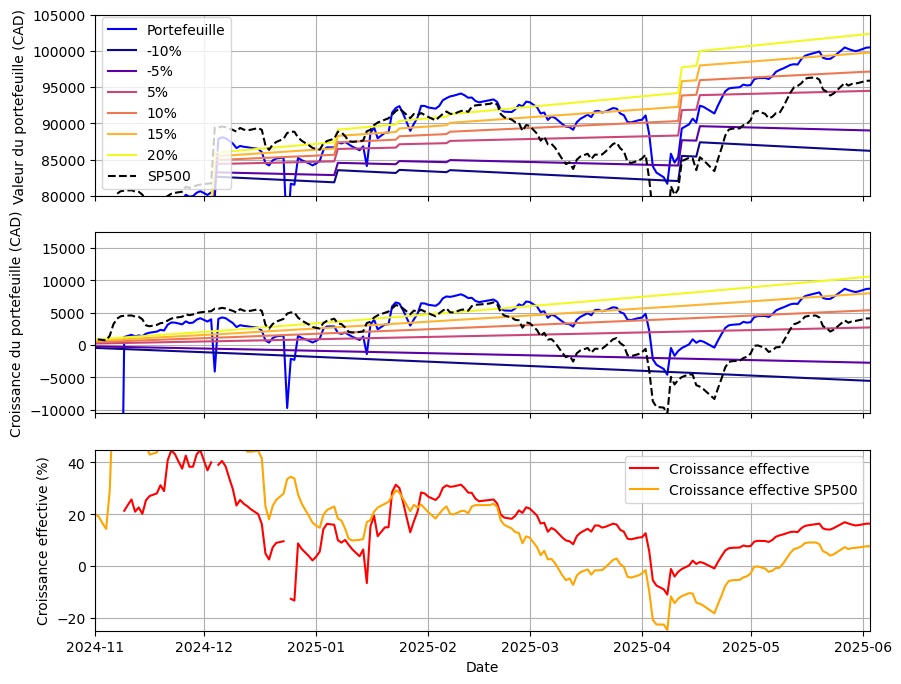

In [29]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(10, 8), sharex=True)

tbl0['time_plot'] = Time(tbl0['mjd'], format='mjd').datetime
#ax[1].plot(tbl0['time_plot'],tbl0['val_total']/tbl0['CONTRIBUTIONS'],'go')
#ax[1].set_ylim([0.9,1.2])

for i in range(2):
    if i == 0:
        ref = 0
    else:
        ref = tbl0['CONTRIBUTIONS']
    ax[i].plot(tbl0['time_plot'],tbl0['val_total']-ref, label='Portefeuille', color='blue')

    max_gain = np.max(tbl0['val_total']-tbl0['CONTRIBUTIONS'])
    #].set_ylim([-5000,max_gain+5000])


    # Use a heat palette for the percent_gains lines
    norm = mcolors.Normalize(vmin=min(percent_gains), vmax=max(percent_gains))
    cmap = cm.get_cmap('plasma')  # or 'viridis', 'inferno', etc.

    for pg in percent_gains:
        color = cmap(norm(pg))

        ax[i].plot(
            tbl0['time_plot'],
            tbl0[f'growth_{pg}_percent'] - ref,
            label=f'{pg}%',
            color=color
        )

    ax[i].plot(tbl0['time_plot'],tbl0['val_SP500']-ref, label='SP500', color='black', linestyle='--')
maxi = np.max(            tbl0[f'growth_{pg}_percent'] - ref)

ax[2].plot(tbl0['time_plot'], tbl0['effective_growth'] , label='Croissance effective', color='red')
ax[2].plot(tbl0['time_plot'], tbl0['effective_growth_sp500'] , label='Croissance effective SP500', color='orange')

ax[0].set_ylim([80000,105000])
ax[1].set_ylim([-maxi,1.5*(maxi*1.1)])
ax[2].set_ylim([-25,45])
ax[0].legend()
ax[2].legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[2].set_xlabel('Date')
ax[0].set_ylabel('Valeur du portefeuille (CAD)')
ax[1].set_ylabel('Croissance du portefeuille (CAD)')
ax[2].set_ylabel('Croissance effective (%)')
ax[0].set_xlim(Time('2024-11-01', format='iso').datetime, Time.now().datetime)
plt.show()





In [30]:
latest_portfolio = []
vv = np.zeros(len(tbl0), dtype=float)
total_last = 0.0
for sym in symbols: 
    last_quantity = tbl0[sym+'_quantity'][-1]
    if last_quantity == 0:
        continue
    last_val = tbl0[sym+'_val'][-1]
    total_last += last_val
    print(f'{sym:<10}','\t', last_quantity,'\t', f'{bt.pdollar(last_val):<10}')
    latest_portfolio.append((sym, last_quantity, last_val))

    tmp = np.array(tbl0[sym+'_dividend'])
    tmp/=tmp[0]
    tmp*= last_quantity
    vv += tmp

print('Total:', bt.pdollar(total_last))



BKCL-C     	 201 	 3 819,00$ 
DMEC-C     	 343 	 8 434,37$ 
DRFC-C     	 656 	 23 058,40$
EBNK-C     	 448 	 6 164,48$ 
HURA-C     	 135 	 4 801,95$ 
XUSC.U-C   	 271 	 11 899,61$
ZEA-C      	 760 	 19 623,20$
ZGLD-C     	 114 	 5 688,60$ 
ZLU.U-C    	 308 	 16 998,52$
Total: 100 488,13$


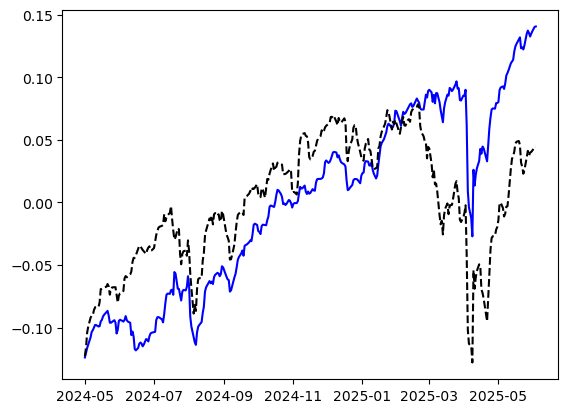

Effective mean growth: 22.134233742676486
Effective mean growth SP500: 7.591906866122936


In [31]:






plt.plot(tbl0['time_plot'], np.log(vv)-np.mean(np.log(vv)), label='Portefeuille', color='blue')
vv_sp500 = tbl0['SP500'] 
plt.plot(tbl0['time_plot'], np.log(vv_sp500)-np.mean(np.log(vv_sp500)), label='SP500', color='black', linestyle='--')
plt.show()

fit = np.polyfit(tbl0['mjd']/364.24,np.log(vv), 1)
print('Effective mean growth:', fit[0]*100.0)
print('Effective mean growth SP500:', np.polyfit(tbl0['mjd']/364.24,np.log(tbl0['SP500']), 1)[0]*100.0)

In [32]:

current_value = tbl0['val_total'][-1] #95450.78

#input keys
keys = 'COTISATION','TRANSFERT REÇU'

keep_injection = [tbl['Type de transaction'][i] in keys for i in range(len(tbl))]

tbl = tbl[keep_injection]
# remove any USD in 'Devise du compte'
tbl = tbl[tbl['Devise du compte'] != 'USD']

tbl["Montant"] = tbl["Montant de l'opération"].astype(float)
tbl['Time_ago'] = Time.now().mjd-Time(tbl['Date de règlement']).mjd

growth_rate = -0.1

def get_current_account(growth_rate):
    return np.sum((1+growth_rate)**(tbl['Time_ago']/365.24)*tbl["Montant"])
def get_val(growth_rate):
    return np.abs(get_current_account(growth_rate)-current_value)

growth_rate = minimize(get_val,0.1).x[0]

total_cost = np.sum(tbl["Montant"])
print(f'Total cost : {total_cost:.2f}$')

value_sp500 =  np.sum(tbl["Montant de l'opération"]/tbl['SP500'])*sp500['Close'][-1]

print(f'Value SP500 : {value_sp500:.2f}$')

current_computed = get_current_account(growth_rate)
print(f'Current -computed- : {current_computed:.2f}$')
print(f'Current growth rate : {100*growth_rate:.2f}%')
print(f'Latest value of SP500 : {sp500["Close"][-1]}$')
print(f'Value if investing everything in SP500 : {value_sp500:.2f}$')

Total cost : 91784.51$
Value SP500 : 95984.07$
Current -computed- : 100488.13$
Current growth rate : 16.29%
Latest value of SP500 : 5935.93994140625$
Value if investing everything in SP500 : 95984.07$


In [33]:
print(tbl)
print(sp500['Close'][-1])

Date de transaction Date de règlement ... Montant       Time_ago     
------------------- ----------------- ... -------- ------------------
         2024-05-07        2024-05-07 ...   6500.0 392.05899088276783
         2024-05-07        2024-05-07 ...     28.0 392.05899088276783
         2024-05-14        2024-05-14 ...    988.8 385.05899088276783
         2024-08-15        2024-08-15 ...   2000.0 292.05899088276783
         2024-08-16        2024-08-16 ...  1054.62 291.05899088276783
         2024-08-20        2024-08-20 ...   362.91 287.05899088276783
         2024-09-23        2024-09-23 ...   450.37 253.05899088276783
         2024-09-23        2024-09-23 ...   450.37 253.05899088276783
         2024-10-07        2024-10-07 ...   651.57 239.05899088276783
         2024-10-31        2024-10-31 ... 63725.51 215.05899088276783
         2024-11-25        2024-11-25 ...    299.0 190.05899088276783
         2024-12-03        2024-12-03 ...   450.12 182.05899088276783
         2024-12-03 